In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

In [2]:
bitcoin_df = pd.read_csv('D:/python3/data/market_price.csv', names = ['ds', 'y'], sep=",")

bitcoin_df.head()

,ds,y
0,Timestamp,market-price
1,2021-03-13 00:00:00,57253.28
2,2021-03-14 00:00:00,61258.73
3,2021-03-15 00:00:00,59133.47
4,2021-03-16 00:00:00,55754.72


In [3]:
bitcoin_df = bitcoin_df.iloc[1:]
bitcoin_df.head()

,ds,y
1,2021-03-13 00:00:00,57253.28
2,2021-03-14 00:00:00,61258.73
3,2021-03-15 00:00:00,59133.47
4,2021-03-16 00:00:00,55754.72
5,2021-03-17 00:00:00,56872.38


In [4]:
# bitcoin_df['ds'] = pd.to_datetime(bitcoin_df['ds'])
# bitcoin_df.head()


In [5]:
# bitcoin_df.index = bitcoin_df['ds']
# bitcoin_df.set_index('ds', inplace = True)
# bitcoin_df.head()

In [6]:
bitcoin_df['y'] = bitcoin_df['y'].astype(float)
bitcoin_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 61 entries, 1 to 61
Data columns (total 2 columns):
ds    61 non-null object
y     61 non-null float64
dtypes: float64(1), object(1)
memory usage: 1.0+ KB


In [7]:
# bitcoin_df.plot()
# plt.show()

In [8]:
# 한데이터로 학습과 test로 나눌 때 연습으로 이렇게 사용
bitcoin_df_1 = bitcoin_df[:-5]
bitcoin_df_2 = bitcoin_df[-5:]

### Prophet 예측법

In [9]:
from sklearn.metrics import mean_squared_error, r2_score
from math import sqrt
from fbprophet import Prophet

prophet = Prophet(seasonality_mode = 'multiplicative', # multiplicative :여러시즌을 담게다는 의미.
                 yearly_seasonality = True,
                 weekly_seasonality = True,
                 daily_seasonality = True,
                 changepoint_prior_scale =0.5) 

# 모델 학습
prophet.fit(bitcoin_df_1)

Importing plotly failed. Interactive plots will not work.


In [10]:
# 5일을 내다보며 예측하는 작업
future_data = prophet.make_future_dataframe(periods = 5, freq = 'd') # 5: 5일, d: 차분(일단위로 생각O)
forecast_data = prophet.predict(future_data)
forecast_data[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()
# yhat : 예측값

,ds,yhat,yhat_lower,yhat_upper
56,2021-05-08,66046.471810,65210.764218,66948.795793
57,2021-05-09,72337.609477,71226.482932,73433.620046
58,2021-05-10,74051.458253,72505.956998,75536.433017
59,2021-05-11,84273.125554,81974.929637,86629.612763
60,2021-05-12,90520.445608,86937.637032,94049.980023


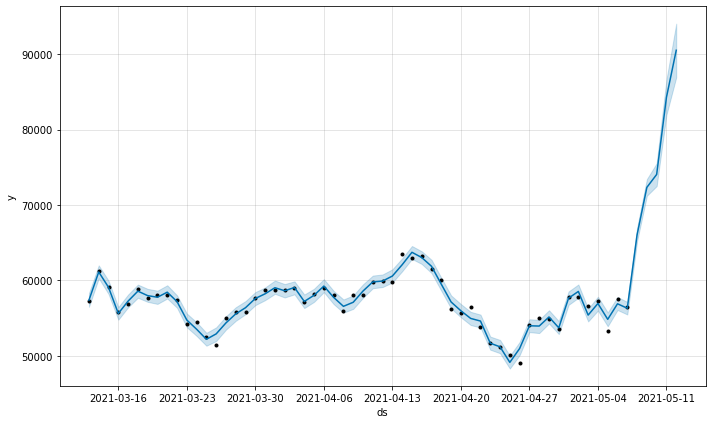

In [11]:
fig1 = prophet.plot(forecast_data)

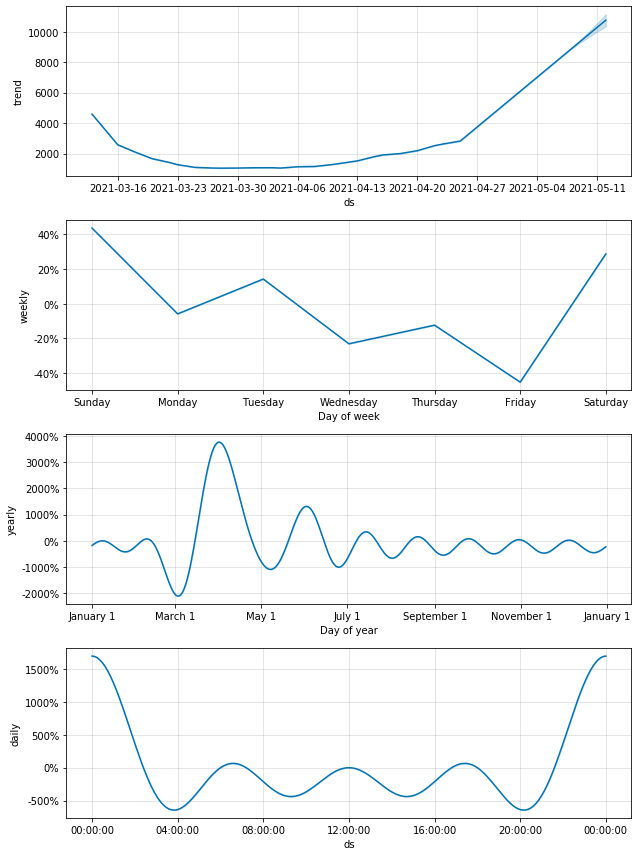

In [12]:
# 일간, 주간, 년간
fig2 = prophet.plot_components(forecast_data)

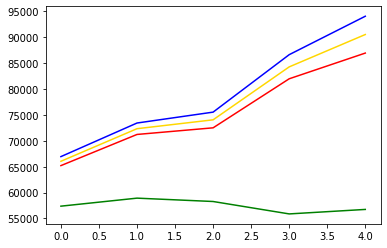

In [13]:
bitcoin_test_df = bitcoin_df_2

pred_y = forecast_data.yhat.values[-5:]
test_y = bitcoin_test_df.y.values
pred_y_lower = forecast_data.yhat_lower.values[-5:]
pred_y_upper = forecast_data.yhat_upper.values[-5:]

plt.plot(pred_y, color = 'gold')
plt.plot(pred_y_lower, color = 'red')
plt.plot(pred_y_upper, color = 'blue')
plt.plot(test_y, color = 'green')

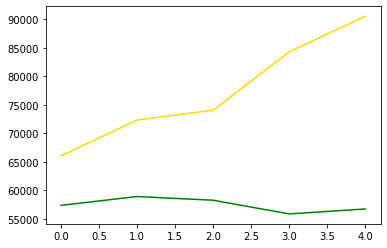

In [14]:
plt.plot(pred_y, color = 'gold')
plt.plot(test_y, color = 'green')

In [15]:
y = bitcoin_df_1.y.values[5:]
y_pred = forecast_data.yhat.values[5:-5]

In [16]:
rmse = sqrt(mean_squared_error(y, y_pred))
r2 = r2_score(y, y_pred)
print(rmse)
print(r2)
# rmse가 낮을 수록 좋은 모델

708.5533759397206
0.9489211866547745


In [17]:
# 만약 rmse가 낮고 r2 점수도 낮으면
# r2 점수가 높은 것으로 채택

### arima 예측법

In [18]:
bitcoin_df_1.index = bitcoin_df_1['ds']
bitcoin_df_1.set_index('ds', inplace = True)

In [19]:
bitcoin_df_1.head()

,y
ds,
2021-03-13 00:00:00,57253.28
2021-03-14 00:00:00,61258.73
2021-03-15 00:00:00,59133.47
2021-03-16 00:00:00,55754.72
2021-03-17 00:00:00,56872.38


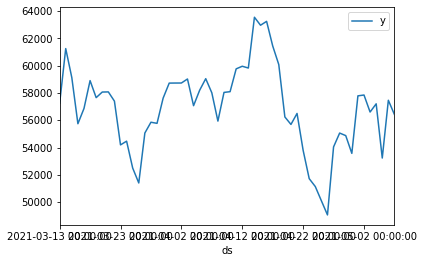

In [20]:
bitcoin_df_1.plot()
plt.show()

In [21]:
from statsmodels.tsa.arima_model import ARIMA# tsa : time Series
import statsmodels.api as sm

# AR = 2(p), 차분(d) = 1(d), MA = 2(q)
# 차분 : 임의 두 점에서의 함수 값들의 차이
model = ARIMA(bitcoin_df_1, order=(2, 1, 2))

# trend : constant를 가지고 있으면 c(constant) / nc(no constant)
# disp : 수렴정보를 나타냄                      선택한 값이 유일한지
model_fit = model.fit(trend = 'c', disp = True, full_output = True)
#               coef, pvalue = 0.813 -> 문제가 되면 nc 사용
# 학습내용 summary
model_fit.summary()

C:\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\anaconda3\lib\site-packages\statsmodels\base\model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:                    D.y   No. Observations:                   55
Model:                 ARIMA(2, 1, 2)   Log Likelihood                -492.855
Method:                       css-mle   S.D. of innovations           1818.811
Date:                Wed, 12 May 2021   AIC                            997.709
Time:                        13:11:30   BIC                           1009.753
Sample:                    03-14-2021   HQIC                          1002.367
                         - 05-07-2021                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        -39.2655    253.050     -0.155      0.877    -535.234     456.703
ar.L1.D.y     -0.8422      0.037    -22.578      0.000      -0.915      -0.769
ar.L2.D.y     -0.9868      0.031    -31.886      0.000      -1.047      -0.926
ma.L1.D.y      0.9169      0.090     10.235      0.000       0.741       1.092
ma.L2.D.y      1.0000      0.073     13.714      0.000       0.857       1.143
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1           -0.4267           -0.9118j            1.0067           -0.3197
AR.2           -0.4267           +0.9118j            1.0067            0.3197
MA.1           -0.4584           -0.8887j            1.0000           -0.3258
MA.2           -0.4584           +0.8887j            1.0000            0.3258
-----------------------------------------------------------------------------
"""

In [22]:
# from pmdarima.arima import auto_arima
# model_arima = auto_arima(bitcoin_df_1, trace=True, error_action= 'ignore', 
#                          start_p =1, start_q = 1, max_p = 3, max_q = 3,
#                          suppress_warnings = True, stepwise = False, seasonal = False)

# model_arima.fit(bitcoin_df_1)

In [23]:
# bitcoin_df_1.head()

In [24]:
# # AR = 2(p), 차분(d) = 1(d), MA = 2(q)
# model = ARIMA(bitcoin_df_1, order=(1, 0, 1))

# # trend : constant를 가지고 있으면 c(constant) / nc(no constant)
# # disp : 수렴정보를 나타냄                      선택한 값이 유일한지
# model_fit = model.fit(trend = 'c', disp = True, full_output = True)
# #               coef, pvalue = 0.813 -> 문제가 되면 nc 사용
# # 학습내용 summary
# model_fit.summary()

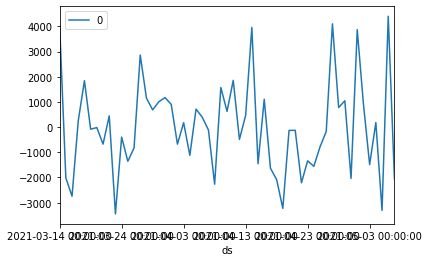

In [26]:
# plot_predict() : (시계열 예측) 학습데이터만을 가지고 예측한 결과 
#fig = model_fit.plot_predict()

# 잔차의 변동을 시각화 
residuals = pd.DataFrame(model_fit.resid)
residuals.plot()
plt.show()

In [27]:
forecast_data = model_fit.forecast(steps = 5) # steps = 5 : 5일

# test data 로딩
bitcoin_test_df = pd.read_csv('D:/python3/data/market-price-test.csv', names = ['ds', 'y'])
bitcoin_test_df

,ds,y
0,2018-08-27 00:00:00,6719.266154
1,2018-08-28 00:00:00,7000.040000
2,2018-08-29 00:00:00,7054.276429
3,2018-08-30 00:00:00,6932.662500
4,2018-08-31 00:00:00,6981.946154


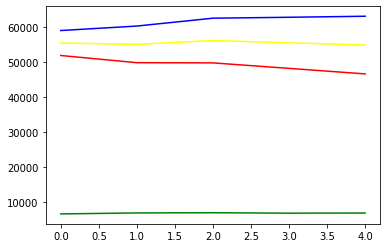

In [28]:
# 마지막 5일의 예측 데이터
pred_y = forecast_data[0].tolist()

# 실제 5일의 데이터
test_y = bitcoin_test_df.y.values

# 마지막 5일의 예측 데이터중 최소값
pred_y_lower = []

# 마지막 5일 예측 데이터의 최대값
pred_y_upper = []

for lower_upper in forecast_data[2]:
    lower = lower_upper[0]
    upper = lower_upper[1]
    pred_y_lower.append(lower)
    pred_y_upper.append(upper)

# 모델이 예상한 가격을 나타내는 그래프
plt.plot(pred_y, color = 'yellow')

# 모델이 예상한 가격의 최솟값을 나타내는 그래프
plt.plot(pred_y_lower, color = 'red')

# 모델이 예상한 가격의 최대값을 나타내는 그래프
plt.plot(pred_y_upper, color = 'blue')

# 실제 가격을 나타내는 그래프
plt.plot(test_y, color = 'green')

plt.show()

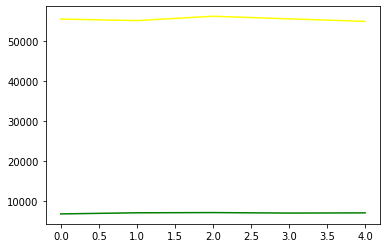

In [29]:
# 모델이 예상한 가격을 나타내는 그래프
plt.plot(pred_y, color = 'yellow')

# 실제 가격을 나타내는 그래프
plt.plot(test_y, color = 'green')


In [30]:
from sklearn.metrics import mean_squared_error, r2_score
from math import sqrt
# RMSE : 모델의 예측값과 실제값의 차이를 하나의 숫자로 표현
rmse = mean_squared_error(test_y, pred_y) ** 0.5 # ** 0.5는 임의대로 한 것-> 가능 하다는 의미
r2 = r2_score(test_y, pred_y)
#rmse = sqrt(mean_squared_error(pred_y, test_y))
print(rmse) # 기준이 없어 낮다 높다 할수 없다 265.1740064802803
print(r2)

48559.390950999375
-175517.64119884904
